In [2]:
# importing necessary libraries

import pandas as pd
import numpy as np
from scipy.spatial import cKDTree
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option("display.max_columns" , None)

In [3]:
# loading the datasets

train = pd.read_csv("/Users/kishikamahajan/Desktop/ADSP_ML1/project2/Train.csv")
test = pd.read_csv("/Users/kishikamahajan/Desktop/ADSP_ML1/project2/Test.csv")
toilets = pd.read_csv("/Users/kishikamahajan/Desktop/ADSP_ML1/project2/toilets.csv")
waste_management = pd.read_csv("/Users/kishikamahajan/Desktop/ADSP_ML1/project2/waste_management.csv")
water_sources = pd.read_csv("/Users/kishikamahajan/Desktop/ADSP_ML1/project2/water_sources.csv")

In [4]:
# Combine train and test datasets for consistent preprocessing
hospital_data = pd.concat([train, test])

In [5]:
# Drop unnecessary columns from supplementary datasets
for df in [toilets, waste_management, water_sources]:
    df.drop(columns=['Year', 'Month'], inplace=True)

In [6]:
# Rename columns for clarity
def rename_columns(df, prefix):
    for col in df.columns:
        if col not in ['Month_Year_lat_lon', 'lat_lon']:
            df.rename(columns={col: f"{prefix}_{col}"}, inplace=True)

rename_columns(toilets, "toilet")
rename_columns(waste_management, "waste")
rename_columns(water_sources, "water")


In [7]:
# Fill missing values in the 'Total' column
hospital_data['Total'].fillna(0, inplace=True)

/var/folders/w0/cccpmsxn11z4l65wxv069v7m0000gn/T/ipykernel_65710/3418388177.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  hospital_data['Total'].fillna(0, inplace=True)


In [8]:
# Drop rows with missing latitude and longitude in water sources
water_sources.dropna(subset=['water_Transformed_Latitude'], inplace=True)

In [9]:
def find_nearest(hospital_df, location_df, lat_col, lon_col, id_col):
    # Create a cKDTree for efficient nearest neighbour search
    tree = cKDTree(location_df[[lat_col, lon_col]].values)
    nearest = {}
    # Loop through each hospital and find the nearest site in location_df
    for _, row in hospital_df.iterrows():
        _, idx = tree.query([row['Transformed_Latitude'], row['Transformed_Longitude']])
        nearest[row['ID']] = location_df.iloc[idx][id_col]
    return nearest

In [10]:
# Ensure unique identifier columns exist in all supplementary datasets
for df, prefix in [(toilets, 'toilet'), (waste_management, 'waste'), (water_sources, 'water')]:
    df[f"{prefix}_Month_Year_lat_lon"] = (
        df[f"{prefix}_Month_Year"] + '_' +
        df[f"{prefix}_Transformed_Latitude"].astype(str) + '_' +
        df[f"{prefix}_Transformed_Longitude"].astype(str)
    )

In [11]:
# Merge datasets with nearest locations
merged_data = hospital_data.copy()
datasets = [
    (toilets, 'toilet', 'toilet_Month_Year_lat_lon'),
    (waste_management, 'waste', 'waste_Month_Year_lat_lon'),
    (water_sources, 'water', 'water_Month_Year_lat_lon'),
]

In [12]:
for df, prefix, id_col in datasets:
    nearest = find_nearest(merged_data, df, f"{prefix}_Transformed_Latitude", f"{prefix}_Transformed_Longitude", id_col)
    nearest_df = pd.DataFrame(list(nearest.items()), columns=['ID', id_col])
    merged_data = merged_data.merge(nearest_df, on="ID").merge(df, on=id_col)

Adding interactions and spatial features

In [13]:
merged_data_combined = merged_data.copy()

In [14]:
# Adding interaction terms with temperature and precipitation

# Calculate average temperature and precipitation
merged_data_combined['Avg_Temp'] = (
    merged_data_combined['toilet_X2t'] + 
    merged_data_combined['waste_X2t'] + 
    merged_data_combined['water_X2t']
) / 3

merged_data_combined['Avg_Precipitation'] = (
    merged_data_combined['toilet_tp'] + 
    merged_data_combined['waste_tp'] + 
    merged_data_combined['water_tp']
) / 3

# Create the interaction term
merged_data_combined['Temp_x_Precipitation'] = (
    merged_data_combined['Avg_Temp'] * 
    merged_data_combined['Avg_Precipitation']
)

In [15]:
# adding distance to nearby facilities
from geopy.distance import distance

# Calculate the distance from hospital to the corresponding facilities
def calculate_distances(row):
    # Hospital coordinates
    hospital_coords = (row['Transformed_Latitude'], row['Transformed_Longitude'])
    
    # Coordinates for toilet, water, and waste facilities
    toilet_coords = (row['toilet_Transformed_Latitude'], row['toilet_Transformed_Longitude'])
    water_coords = (row['water_Transformed_Latitude'], row['water_Transformed_Longitude'])
    waste_coords = (row['waste_Transformed_Latitude'], row['waste_Transformed_Longitude'])
    
    # Calculate distances
    dist_to_toilet = distance(hospital_coords, toilet_coords).km  # Distance in kilometers
    dist_to_water = distance(hospital_coords, water_coords).km
    dist_to_waste = distance(hospital_coords, waste_coords).km
    
    # Return the distances
    return pd.Series({
        'distance_to_toilet_km': dist_to_toilet,
        'distance_to_water_km': dist_to_water,
        'distance_to_waste_km': dist_to_waste
    })

# Apply the function to your dataframe (assuming it's named 'data')
merged_data_combined[['distance_to_toilet_km', 'distance_to_water_km', 'distance_to_waste_km']] = merged_data_combined.apply(calculate_distances, axis=1)

In [16]:
# adding density of facilities within 3 kms of the hospital

# Function to count unique facilities within 3 km using KD-Tree
def count_nearby_facilities_kdtree(hospitals, facilities, lat_col, lon_col):
    # Get unique facility coordinates
    facility_coords = facilities[[lat_col, lon_col]].drop_duplicates().values
    
    # Create KD-Tree for fast spatial lookup
    tree = cKDTree(np.radians(facility_coords))  # Convert to radians for geodesic distance
    
    # Convert hospital coordinates to radians
    hospital_coords = np.radians(hospitals[['Transformed_Latitude', 'Transformed_Longitude']].values)
    
    # Query KD-Tree for all hospital points with a 2 km radius (approx. 0.018 radians)
    counts = tree.query_ball_point(hospital_coords, r=3 / 6371, return_length=True)  # Earth radius = 6371 km
    
    return counts

# Create separate DataFrames for hospitals and facilities
hospitals_df = merged_data_combined[['Transformed_Latitude', 'Transformed_Longitude']]

# Separate facility datasets (removing duplicates)
toilets_df = merged_data_combined[['toilet_Transformed_Latitude', 'toilet_Transformed_Longitude']].drop_duplicates()
waste_df = merged_data_combined[['waste_Transformed_Latitude', 'waste_Transformed_Longitude']].drop_duplicates()
water_df = merged_data_combined[['water_Transformed_Latitude', 'water_Transformed_Longitude']].drop_duplicates()

# Fast vectorized counting of unique nearby facilities
merged_data_combined['toilets_within_2km'] = count_nearby_facilities_kdtree(hospitals_df, toilets_df, 'toilet_Transformed_Latitude', 'toilet_Transformed_Longitude')
merged_data_combined['waste_within_2km'] = count_nearby_facilities_kdtree(hospitals_df, waste_df, 'waste_Transformed_Latitude', 'waste_Transformed_Longitude')
merged_data_combined['water_within_2km'] = count_nearby_facilities_kdtree(hospitals_df, water_df, 'water_Transformed_Latitude', 'water_Transformed_Longitude')

In [17]:
# Adding distance related interaction terms

# Create the interaction term
merged_data_combined['Distance_x_Precipitation_toilet'] = (
    merged_data_combined['distance_to_toilet_km'] * 
    merged_data_combined['toilet_tp']
)

merged_data_combined['Distance_x_Precipitation_waste'] = (
    merged_data_combined['distance_to_waste_km'] * 
    merged_data_combined['waste_tp']
)

merged_data_combined['Distance_x_Precipitation_water'] = (
    merged_data_combined['distance_to_water_km'] * 
    merged_data_combined['water_tp']
)

In [18]:
# Adding distance related interaction terms
merged_data_combined['distance_to_waste_x_waste_tp'] = merged_data_combined['distance_to_waste_km'] * merged_data_combined['waste_tp']

In [19]:
# Adding distance related interaction terms

merged_data_combined['distance_to_toilet_x_distance_to_water'] = merged_data_combined['distance_to_toilet_km'] * merged_data_combined['distance_to_water_km']
merged_data_combined['distance_to_toilet_x_distance_to_waste'] = merged_data_combined['distance_to_toilet_km'] * merged_data_combined['distance_to_waste_km']
merged_data_combined["distance_to_water_x_distance_to_waste"] = merged_data_combined["distance_to_waste_km"] * merged_data_combined["distance_to_water_km"]
merged_data_combined['Temp_x_Waste_Within_2km'] = merged_data_combined['Avg_Temp'] * merged_data_combined['waste_within_2km']

In [20]:
# Adding distance related interaction terms

merged_data_combined["distance_x_Temp_toilet"] = merged_data_combined["distance_to_toilet_km"] * merged_data_combined["Avg_Temp"]
merged_data_combined["distance_x_Temp_waste"] = merged_data_combined["distance_to_waste_km"] * merged_data_combined["Avg_Temp"]
merged_data_combined["distance_x_Temp_water"] = merged_data_combined["distance_to_water_km"] * merged_data_combined["Avg_Temp"]

In [21]:
# Adding density related interaction terms
merged_data_combined['precipitation_x_num_toilets'] = merged_data_combined['Avg_Precipitation'] * merged_data_combined['toilets_within_2km']
merged_data_combined["preicpitation_x_water_sources"] = merged_data_combined['water_tp'] * merged_data_combined["water_within_2km"]
merged_data_combined["num_toilets_x_num_waste"] = merged_data_combined["toilets_within_2km"] * merged_data_combined["waste_within_2km"]
merged_data_combined["num_water_x_num_waste"] = merged_data_combined["water_within_2km"] * merged_data_combined["waste_within_2km"]
merged_data_combined["precip_x_num_water"] = merged_data_combined["Avg_Precipitation"] * merged_data_combined["water_within_2km"]

In [22]:
merged_data_combined['Distance_to_Toilet_x_Toilets_Within_2km'] = merged_data_combined['distance_to_toilet_km'] * merged_data_combined['toilets_within_2km']
merged_data_combined['Distance_to_Water_x_Water_Within_2km'] = merged_data_combined['distance_to_water_km'] * merged_data_combined['water_within_2km']
merged_data_combined['Distance_to_Waste_x_Waste_Within_2km'] = merged_data_combined['distance_to_waste_km'] * merged_data_combined['waste_within_2km']

In [23]:
merged_data_combined.head()

,Unnamed: 0,ID,Total,Location,Category_Health_Facility_UUID,Disease,Month,Year,Transformed_Latitude,Transformed_Longitude,toilet_Month_Year_lat_lon,toilet_Unnamed: 0,toilet_X10u,toilet_X10v,toilet_X2d,toilet_X2t,toilet_evabs,toilet_evaow,toilet_evatc,toilet_evavt,toilet_albedo,toilet_lshf,toilet_lai_hv,toilet_lai_lv,toilet_pev,toilet_ro,toilet_src,toilet_skt,toilet_es,toilet_stl1,toilet_stl2,toilet_stl3,toilet_stl4,toilet_ssro,toilet_slhf,toilet_ssr,toilet_str,toilet_sp,toilet_sro,toilet_sshf,toilet_ssrd,toilet_strd,toilet_e,toilet_tp,toilet_swvl1,toilet_swvl2,toilet_swvl3,toilet_swvl4,toilet_Transformed_Latitude,toilet_Transformed_Longitude,toilet_Month_Year,lat_lon_x,Month_Year_lat_lon_x,waste_Month_Year_lat_lon,waste_Unnamed: 0,waste_X10u,waste_X10v,waste_X2d,waste_X2t,waste_evabs,waste_evaow,waste_evatc,waste_evavt,waste_albedo,waste_lshf,waste_lai_hv,waste_lai_lv,waste_pev,waste_ro,waste_src,waste_skt,waste_es,waste_stl1,waste_stl2,waste_stl3,waste_stl4,waste_ssro,waste_slhf,waste_ssr,waste_str,waste_sp,waste_sro,waste_sshf,waste_ssrd,waste_strd,waste_e,waste_tp,waste_swvl1,waste_swvl2,waste_swvl3,waste_swvl4,waste_Transformed_Latitude,waste_Transformed_Longitude,waste_Month_Year,lat_lon_y,Month_Year_lat_lon_y,water_Month_Year_lat_lon,water_Unnamed: 0,water_X10u,water_X10v,water_X2d,water_X2t,water_evabs,water_evaow,water_evatc,water_evavt,water_albedo,water_lshf,water_lai_hv,water_lai_lv,water_pev,water_ro,water_src,water_skt,water_es,water_stl1,water_stl2,water_stl3,water_stl4,water_ssro,water_slhf,water_ssr,water_str,water_sp,water_sro,water_sshf,water_ssrd,water_strd,water_e,water_tp,water_swvl1,water_swvl2,water_swvl3,water_swvl4,water_Transformed_Latitude,water_Transformed_Longitude,water_Month_Year,lat_lon,Month_Year_lat_lon,Avg_Temp,Avg_Precipitation,Temp_x_Precipitation,distance_to_toilet_km,distance_to_water_km,distance_to_waste_km,toilets_within_2km,waste_within_2km,water_within_2km,Distance_x_Precipitation_toilet,Distance_x_Precipitation_waste,Distance_x_Precipitation_water,distance_to_waste_x_waste_tp,distance_to_toilet_x_distance_to_water,distance_to_toilet_x_distance_to_waste,distance_to_water_x_distance_to_waste,Temp_x_Waste_Within_2km,distance_x_Temp_toilet,distance_x_Temp_waste,distance_x_Temp_water,precipitation_x_num_toilets,preicpitation_x_water_sources,num_toilets_x_num_waste,num_water_x_num_waste,precip_x_num_water,Distance_to_Toilet_x_Toilets_Within_2km,Distance_to_Water_x_Water_Within_2km,Distance_to_Waste_x_Waste_Within_2km
0,1,ID_3a11929e-3317-476d-99f7-1bd9fb58f018_6_2022...,0.0,ID_3a11929e-3317-476d-99f7-1bd9fb58f018,a9280aca-c872-46f5-ada7-4a7cc31cf6ec,Dysentery,6,2022,-8.62982,68.23267,4_2019_-8.62979_68.23582,718,-0.392348,0.384925,293.934,296.542,-0.001748,-0.000658,-0.001343,-2.700840e-08,0.180959,0.650017,4.77283,1.94531,-0.008219,0.000922,0.000234,297.1,2.328310e-10,297.811,297.933,298.283,298.588,0.000025,-9375320,13806700,-2404380,93336.3,0.000898,-2148780,16857400,35712800,-0.003749,0.007518,0.385513,0.378616,0.309784,0.288925,-8.62979,68.23582,4_2019,-8.62979_68.23582,4_2019_-8.62979_68.23582,6_2022_-8.62861_68.23612,420,-0.360747,1.163,287.625,294.228,-0.001532,-0.000477,-0.000216,-2.887100e-08,0.180208,0.649994,4.69702,1.8772,-0.013374,0.000043,0.000032,294.918,1.164150e-10,295.637,295.903,296.546,297.469,0.000038,-5565310,13882400,-4452810,93818.0,0.000005,-4053900,16934300,32432000,-0.002225,0.000587,0.1548,0.201248,0.277847,0.288361,-8.62861,68.23612,6_2022,-8.62861_68.23612,6_2022_-8.62861_68.23612,6_2022_-8.62966_68.23589,924,-0.360747,1.163,287.625,294.228,-0.001532,-0.000477,-0.000216,-2.887100e-08,0.180208,0.649994,4.69702,1.8772,-0.013374,0.000043,0.000032,294.918,1.164150e-10,295.637,295.903,296.546,297.469,0.000038,-5565310,13882400,-4452810,93818.0,0.000005,-4053900,16934300,32432000,-0.002225,0.000587,0.1548,0.201248,0.277847,0.288361,-8.62966,68.23589,6_2022,-8.62966_68.23589,6_2022_-8.62966_68.23589,294.999333,0.002897,0.854653,0.346728,0.354859,0.402625,13,18,17,0.

**Start Modelling**

<Axes: >

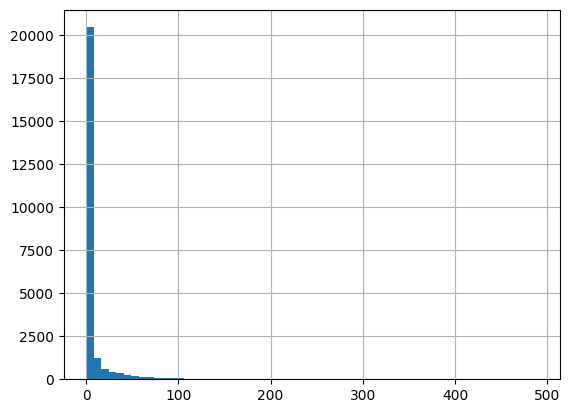

In [24]:
merged_data_combined["Total"].hist(bins = 60)

In [25]:
# Split merged data into training, validation and test sets
train_df_combined = merged_data_combined[(merged_data_combined['Year'] <= 2022) & (merged_data_combined['Month'] <= 3)]
val_df_combined = merged_data_combined[(merged_data_combined['Year'] == 2022) & (merged_data_combined['Month'] >= 4) & (merged_data_combined['Month'] < 7)]
test_df_combined = merged_data_combined[(merged_data_combined['Year'] == 2022) & (merged_data_combined['Month'] >= 7)]

In [26]:
# Specify the target column
target_column = 'Total'

# Feature and target split
X_train_combined = train_df_combined.drop(columns=[target_column, 'ID', 'Location'])  # Exclude unnecessary columns
y_train = train_df_combined[target_column]

X_val_combined = val_df_combined.drop(columns=[target_column, 'ID', 'Location'])  # Exclude unnecessary columns
y_val = val_df_combined[target_column]

X_test_combined = test_df_combined.drop(columns=[target_column, 'ID', 'Location'])  # Exclude unnecessary columns

In [27]:
import pandas as pd

# Identify categorical columns
categorical_cols_combined = X_train_combined.select_dtypes(include=['object']).columns

# Apply one-hot encoding
X_train_combined = pd.get_dummies(X_train_combined, columns=categorical_cols_combined, drop_first=True)
X_val_combined = pd.get_dummies(X_val_combined, columns=categorical_cols_combined, drop_first=True)
X_test_combined = pd.get_dummies(X_test_combined, columns=categorical_cols_combined, drop_first=True)

# Convert only one-hot encoded columns to int
one_hot_cols = X_train_combined.columns.difference(X_train_combined.select_dtypes(exclude=['uint8', 'bool']).columns)
X_train_combined[one_hot_cols] = X_train_combined[one_hot_cols].astype(int)
X_val_combined[one_hot_cols] = X_val_combined[one_hot_cols].astype(int)
X_test_combined[one_hot_cols] = X_test_combined[one_hot_cols].astype(int)

# Ensure all datasets have the same columns
X_train_combined, X_val_combined = X_train_combined.align(X_val_combined, join='left', axis=1, fill_value=0)
X_train_combined, X_test_combined = X_train_combined.align(X_test_combined, join='left', axis=1, fill_value=0)


As was seen above, the "total" variable is highly skewed so, we can try to log it before training the model and evaluate final results after delogging it. 

In [29]:
# Apply log transformation to the target variables
y_train_log = np.log(y_train + 1e-6)
y_val_log = np.log(y_val + 1e-6)

from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from scipy.stats import randint, uniform
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

# Define hyperparameter grids for XGBoost and Random Forest
xgb_param_grid = {
    'max_depth': randint(3, 10),  
    'learning_rate': uniform(0.01, 0.3), 
    'n_estimators': randint(50, 300),  
    'subsample': uniform(0.8, 0.2),  
    'colsample_bytree': uniform(0.8, 0.2), 
    'gamma': uniform(0, 0.2), 
    'reg_alpha': uniform(0, 1.0),  
    'reg_lambda': uniform(0.1, 1.5) 
}

rf_param_grid = {
    'n_estimators': randint(50, 300),  
    'max_depth': [None] + list(range(3, 10)),  
    'min_samples_split': randint(2, 10),  
    'min_samples_leaf': randint(1, 10),  
    'max_features': ['auto', 'sqrt', 'log2'],  
    'bootstrap': [True, False]  
}

# Time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Hyperparameter tuning for XGBoost
xgb_search = RandomizedSearchCV(
    estimator=XGBRegressor(random_state=42),
    param_distributions=xgb_param_grid,
    n_iter=50,  # Number of parameter settings sampled
    scoring='neg_mean_absolute_error',
    cv=tscv,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Hyperparameter tuning for Random Forest
rf_search = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_distributions=rf_param_grid,
    n_iter=50,  # Number of parameter settings sampled
    scoring='neg_mean_absolute_error',
    cv=tscv,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

xgb_search.fit(X_train_combined, y_train_log)
rf_search.fit(X_train_combined, y_train_log)

# Getting the best hyperparameters
best_xgb_params = xgb_search.best_params_
best_rf_params = rf_search.best_params_

print("Best XGBoost Parameters:", best_xgb_params)
print("Best Random Forest Parameters:", best_rf_params)

# Defining base models with the best hyperparameters
xgb_model = XGBRegressor(random_state=42, **best_xgb_params)
rf_model = RandomForestRegressor(random_state=42, **best_rf_params)

# Defining linear regression as the meta-model 
meta_model = LinearRegression()

# Create the stacking model 
stacking_model = StackingRegressor(
    estimators=[
        ('xgb', xgb_model),  
        ('rf', rf_model)  
    ],
    final_estimator=meta_model 
)

# Train the stacking model on the log-transformed target variable
stacking_model.fit(X_train_combined, y_train_log)

# Make predictions on Training data (log scale)
y_pred_train_log_stacking = stacking_model.predict(X_train_combined)

# Evaluating the model on Training data (log scale) 
mae_train_log_stacking = mean_absolute_error(y_train_log, y_pred_train_log_stacking)
print(f"Training MAE (log scale) stacking model: {mae_train_log_stacking}")

# Make predictions on Validation data (log scale)
y_pred_val_log_stacking = stacking_model.predict(X_val_combined)

# Evaluating the model on Validation data 
mae_val_log_stacking = mean_absolute_error(y_val_log, y_pred_val_log_stacking)
print(f"Validation MAE (log scale) stacking model: {mae_val_log_stacking}")

# Now, exponentiating the predicted values to bring them back to the original scale
y_pred_train_stacking = np.exp(y_pred_train_log_stacking)
y_pred_val_stacking = np.exp(y_pred_val_log_stacking)

# Evaluating the model on Training data (original scale) 
mae_train_stacking_delog = mean_absolute_error(y_train, y_pred_train_stacking)
print(f"Training MAE (original scale) stacking model after delogging: {mae_train_stacking_delog}")

# Evaluating the model on Validation data (original scale) 
mae_val_stacking_delog = mean_absolute_error(y_val, y_pred_val_stacking)
print(f"Validation MAE (original scale) stacking model after delogging: {mae_val_stacking_delog}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END colsample_bytree=0.8749080237694725, gamma=0.19014286128198324, learning_rate=0.22959818254342154, max_depth=7, n_estimators=70, reg_alpha=0.15601864044243652, reg_lambda=0.333991780504304, subsample=0.8116167224336399; total time=   0.4s
[CV] END colsample_bytree=0.8749080237694725, gamma=0.19014286128198324, learning_rate=0.22959818254342154, max_depth=7, n_estimators=70, reg_alpha=0.15601864044243652, reg_lambda=0.333991780504304, subsample=0.8116167224336399; total time=   0.5s
[CV] END colsample_bytree=0.9732352291549871, gamma=0.12022300234864176, learning_rate=0.22242177333881366, max_depth=8, n_estimators=102, reg_alpha=0.9699098521619943, reg_lambda=1.3486639612006326, subsample=0.8424678221356553; total time=   0.6s
[CV] END colsample_bytree=0.8749080237694725, gamma=0.19014286128198324, learning_rate=0.22959818254342154, max_depth=7, n_estimators=70, reg_alpha=0.15601864044243652, reg_lambda=0.33399178050

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
90 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/

Best XGBoost Parameters: {'colsample_bytree': np.float64(0.8240329295611285), 'gamma': np.float64(0.06837593334328032), 'learning_rate': np.float64(0.037539719744032564), 'max_depth': 9, 'n_estimators': 290, 'reg_alpha': np.float64(0.3114133093912942), 'reg_lambda': np.float64(1.5692657929322629), 'subsample': np.float64(0.8350660539778677)}
Best Random Forest Parameters: {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 51}
Training MAE (log scale) stacking model: 4.564809646443452
Validation MAE (log scale) stacking model: 5.039373254081817
Training MAE (original scale) stacking model after delogging: 10.160960471067787
Validation MAE (original scale) stacking model after delogging: 6.719949944815001


In [30]:
# Prepare test data
X_test_final = X_test_combined.drop(columns=['Total'], errors='ignore')

# Align test dataset with training features
for col in X_train_combined.columns:
    if col not in X_test_final.columns:
        X_test_final[col] = 0  

# Ensure columns are in the same order as training
X_test_final = X_test_final[X_train_combined.columns]

# Make predictions on test data (log scale)
y_pred_test_log_stacking = stacking_model.predict(X_test_final)

# Exponentiate the predicted values to bring them back to the original scale
y_pred_test_stacking = np.exp(y_pred_test_log_stacking)

sub = test_df_combined[['ID']].copy()
sub['Predicted_Total'] = y_pred_test_stacking

sub.head()

,ID,Predicted_Total
20592,ID_3a11929e-3317-476d-99f7-1bd9fb58f018_12_202...,0.000001
20593,ID_3a11929e-3317-476d-99f7-1bd9fb58f018_12_202...,0.000006
20594,ID_3a11929e-3317-476d-99f7-1bd9fb58f018_12_202...,0.000004
20595,ID_3a11929e-3317-476d-99f7-1bd9fb58f018_12_202...,0.000004
20596,ID_3a11929e-3317-476d-99f7-1bd9fb58f018_12_202...,0.000004


In [604]:
# Save the predictions to a CSV file
sub.to_csv('stacking_model_predictions.csv', index=False)